In [1]:
# coding: utf-8
from typing import Dict, Optional

import pandas as pd
import plotly.express as px

from data.data_loader import PykrxDataLoader
from simulation.account import Account
from simulation.broker import Broker
from simulation.utility import get_lookback_fromdate
from simulation.utility import rebalance
from simulation.metric import cagr, mdd, sharpe_ratio, sortino_ratio

# 이동평균 전략 정의하기

In [2]:
def calculate_MA(ohlcv_data: pd.DataFrame,
                 period: int,
                 ma_type: str) -> pd.DataFrame:
    # 종가 데이터 만들기
    close_data = ohlcv_data[['close', 'ticker']].reset_index().set_index(
        ['ticker', 'date']).unstack(level=0)
    close_data = close_data['close']

    # 이동평균 계산하기
    if ma_type == 'sma':
        ma = close_data.rolling(window=period).mean()
    elif ma_type == 'ema':
        ma = close_data.ewm(span=period).mean()
    else:
        raise ValueError

    return ma


def get_moving_average_weights(ohlcv_data: pd.DataFrame,
                               ma_data: pd.DataFrame) -> Optional[Dict]:
    # 이동평균 데이터 중 결측치가 있는지 확인함
    if ma_data.isnull().values.any():
        return None

    # 이동평균 전략에 필요한 변수 정의
    portfolio = {}
    stocks_to_buy = []

    # 매수할 주식과 매도할 주식을 선정함
    for ticker in ohlcv_data['ticker']:
        # 종가 > 이동평균
        if ohlcv_data.loc[ohlcv_data['ticker'] == ticker, 'close'].values > ma_data[ticker]:
            stocks_to_buy.append(ticker)
        # 종가 <= 이동평균
        else:
            portfolio[ticker] = 0.0

    # 매수할 주식이 없는 경우 포트폴리오 반환
    if not stocks_to_buy:
        return portfolio

    # 매수할 주식 비율을 할당함
    weights = 1 / len(stocks_to_buy)
    for ticker in stocks_to_buy:
        portfolio[ticker] = weights

    return portfolio

# 이동평균 전략을 이용한 시뮬레이션 함수 정의하기

In [3]:
def simulate_moving_average(ohlcv_data: pd.DataFrame,
                            ma_type: str,
                            period: int) -> Account:
    # 1. 계좌 및 브로커 선언
    account = Account(initial_cash=100000000)
    broker = Broker()

    # 2. 이동평균 계산
    ma = calculate_MA(ohlcv_data=ohlcv_data, period=period, ma_type=ma_type)

    for date, ohlcv in ohlcv_data.groupby(['date']):
        print(date.date())

        # 3. 주문 집행 및 계좌 갱신
        transactions = broker.process_order(dt=date, data=ohlcv, orders=account.orders)
        account.update_position(transactions=transactions)
        account.update_portfolio(dt=date, data=ohlcv)
        account.update_order()

        # 4. 이동평균 전략을 이용하여 포트폴리오 구성
        ma_slice = ma.loc[date]
        weights = get_moving_average_weights(ohlcv_data=ohlcv, ma_data=ma_slice)

        print(f'Portfolio: {weights}')
        if weights is None:
            continue

        # 5. 주문
        rebalance(dt=date, data=ohlcv, account=account, weights=weights)

    return account

# 이동평균 전략 실행하기

In [4]:
# 데이터 시작과 끝 날짜 정의
fromdate = '2018-07-10'
todate = '2023-09-27'

# 투자할 종목 후보 정의
ticker_list = ['005930', '000660', '207940',
               '051910', '006400', '005380',
               '000270', '005490', '035420']

In [5]:
# 이동평균 기간 정의
period = 3

# 기간을 고려한 데이터 시작 날짜 가져오기
adj_fromdate = get_lookback_fromdate(fromdate=fromdate, lookback=period, freq='m')

# 데이터 불러오기
data_loader = PykrxDataLoader(fromdate=adj_fromdate, todate=todate, market="KOSPI")
ohlcv_data = data_loader.load_stock_data(ticker_list=ticker_list, freq='m', delay=1)

# 데이터 확인하기
ohlcv_data.head()

,ticker,open,high,low,close,volume,trading_value
date,,,,,,,
2018-05-31,000270,31750,31900,31150,31150,1468344,45905113600
2018-06-30,000270,31100,34000,30450,30850,18456227,592754813860
2018-07-31,000270,30850,32850,29450,31700,17534882,549806413939
2018-08-31,000270,31650,32600,30950,32050,13377137,426503305929
2018-09-30,000270,31900,35600,31350,35100,19573161,667634820273


In [6]:
# 이동평균 종류 정의
ma_type = 'sma'  # {ema, sma}

# 단순이동평균 전략 실행하기
sma_simulation_account = simulate_moving_average(ohlcv_data=ohlcv_data, ma_type=ma_type, period=period)

2018-05-31
Portfolio: None
2018-06-30
Portfolio: None
2018-07-31
Portfolio: {'000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '035420': 0.0, '207940': 0.0, '000270': 0.3333333333333333, '006400': 0.3333333333333333, '051910': 0.3333333333333333}
2018-08-31
Portfolio: {'000660': 0.0, '005380': 0.0, '005490': 0.0, '000270': 0.16666666666666666, '005930': 0.16666666666666666, '006400': 0.16666666666666666, '035420': 0.16666666666666666, '051910': 0.16666666666666666, '207940': 0.16666666666666666}
2018-09-30
Portfolio: {'000660': 0.0, '005490': 0.0, '005930': 0.0, '035420': 0.0, '051910': 0.0, '000270': 0.25, '005380': 0.25, '006400': 0.25, '207940': 0.25}
2018-10-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-11-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-12-31


In [7]:
# 이동평균 종류 정의
ma_type = 'ema'  # {ema, sma}

# 지수이동평균 전략 실행하기
ema_simulation_account = simulate_moving_average(ohlcv_data=ohlcv_data, ma_type=ma_type, period=period)

2018-05-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '006400': 0.0, '035420': 0.0, '051910': 0.0, '207940': 0.0}
2018-06-30
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '051910': 0.0, '207940': 0.0, '006400': 0.5, '035420': 0.5}
2018-07-31
Portfolio: {'000660': 0.0, '005380': 0.0, '005490': 0.0, '005930': 0.0, '035420': 0.0, '207940': 0.0, '000270': 0.3333333333333333, '006400': 0.3333333333333333, '051910': 0.3333333333333333}
2018-08-31
Portfolio: {'000660': 0.0, '005380': 0.0, '005490': 0.0, '000270': 0.16666666666666666, '005930': 0.16666666666666666, '006400': 0.16666666666666666, '035420': 0.16666666666666666, '051910': 0.16666666666666666, '207940': 0.16666666666666666}
2018-09-30
Portfolio: {'000660': 0.0, '005490': 0.0, '005930': 0.0, '035420': 0.0, '000270': 0.2, '005380': 0.2, '006400': 0.2, '051910': 0.2, '207940': 0.2}
2018-10-31
Portfolio: {'000270': 0.0, '000660': 0.0, '005380': 0.0, '

# 투자 결과 분석 하기

In [8]:
sma_account = pd.DataFrame(sma_simulation_account.account_history).set_index('date')
sma_portfolio = pd.DataFrame(sma_simulation_account.portfolio_history).set_index('date')

ema_account = pd.DataFrame(ema_simulation_account.account_history).set_index('date')
ema_portfolio = pd.DataFrame(ema_simulation_account.portfolio_history).set_index('date')

In [9]:
analysis_fromdate = sma_account.index[period]

In [10]:
sma_returns = sma_account['total_asset'].pct_change().loc[analysis_fromdate:]
sma_returns.name = 'sma_return'
sma_returns.head()

date
2018-08-31    0.002467
2018-09-30    0.039815
2018-10-31   -0.183843
2018-11-30    0.002913
2018-12-31    0.000000
Name: sma_return, dtype: float64

In [11]:
ema_returns = ema_account['total_asset'].pct_change().loc[analysis_fromdate:]
ema_returns.name = 'ema_returns'
ema_returns.head()

date
2018-08-31    0.005702
2018-09-30    0.039654
2018-10-31   -0.157244
2018-11-30    0.003920
2018-12-31    0.000000
Name: ema_returns, dtype: float64

In [12]:
kospi = data_loader.load_index_data(ticker_list=['1001'], freq='m', delay=1)
kospi_returns = kospi['close'].pct_change().loc[analysis_fromdate:]
kospi_returns.iloc[0] = 0.0
kospi_returns.name = 'kospi_return'
kospi_returns.index.name = 'date'
kospi_returns.head()

date
2018-08-31    0.000000
2018-09-30    0.008692
2018-10-31   -0.133748
2018-11-30    0.033094
2018-12-31   -0.026621
Freq: M, Name: kospi_return, dtype: float64

## CAGR

In [13]:
cagr(returns=sma_returns, freq='m')

0.06410029533083406

In [14]:
cagr(returns=ema_returns, freq='m')

0.07880334368459962

In [15]:
cagr(returns=kospi_returns, freq='m')

0.011565545720302106

## MDD

In [16]:
mdd(returns=sma_returns)

-0.4642628667320788

In [17]:
mdd(returns=ema_returns)

-0.44689777382208606

In [18]:
mdd(returns=kospi_returns)

-0.3461634128881176

## 샤프비율

In [19]:
sharpe_ratio(returns=sma_returns, freq='m')

0.3700917741688365

In [20]:
sharpe_ratio(returns=ema_returns, freq='m')

0.4269565602379562

In [21]:
sharpe_ratio(returns=kospi_returns, freq='m')

0.15795047009124435

## 소티노비율

In [22]:
sortino_ratio(returns=sma_returns, freq='m')

0.36412755349154585

In [23]:
sortino_ratio(returns=ema_returns, freq='m')

0.4269493875945004

In [24]:
sortino_ratio(returns=kospi_returns, freq='m')

0.14178141657410892

## 누적 수익률

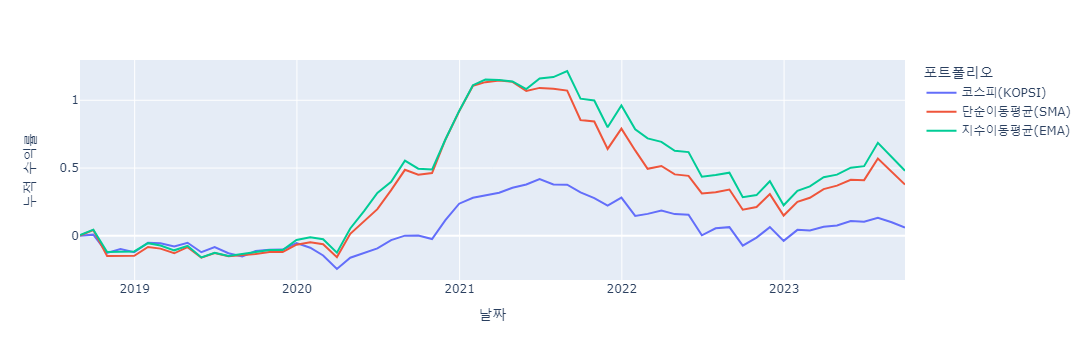

In [26]:
# 누적 수익률 계산하기
benchmark_cum_returns = (kospi_returns + 1).cumprod() - 1
sma_cum_returns = (sma_returns + 1).cumprod() - 1
ema_cum_returns = (ema_returns + 1).cumprod() - 1

# 자산 정보 결합하기
cum_returns = pd.concat([benchmark_cum_returns, sma_cum_returns, ema_cum_returns], axis=1)
cum_returns.columns = ["코스피(KOPSI)", "단순이동평균(SMA)", "지수이동평균(EMA)"]

# 자산 변화 시각화하기
fig = px.line(data_frame=cum_returns)

# x축, y축 레이블 설정
fig.update_xaxes(title_text='날짜')
fig.update_yaxes(title_text='누적 수익률')

# 범례 제목 설정
fig.update_layout(legend_title_text='포트폴리오') 

fig.show()